Feature extraction done.

Logistic Regression
Accuracy: 0.9955441684304334
Precision: 0.9948652118100129
Recall: 0.9965709387055294
F1 Score: 0.9957173447537473
Confusion Matrix:
 [[4287   24]
 [  16 4650]]
Train Accuracy: 1.0000
Test Accuracy: 0.9955
Overfitting Gap (Accuracy): 0.0045
 


Naive Bayes
Accuracy: 0.9475325832683524
Precision: 0.9473235231392622
Recall: 0.951993141877411
F1 Score: 0.9496525921966863
Confusion Matrix:
 [[4064  247]
 [ 224 4442]]
Train Accuracy: 0.9496
Test Accuracy: 0.9475
Overfitting Gap (Accuracy): 0.0021
 


Random Forest
Accuracy: 0.9982176673721733
Precision: 0.9991412623443539
Recall: 0.997428204029147
F1 Score: 0.9982839982839983
Confusion Matrix:
 [[4307    4]
 [  12 4654]]
Train Accuracy: 1.0000
Test Accuracy: 0.9982
Overfitting Gap (Accuracy): 0.0018
 



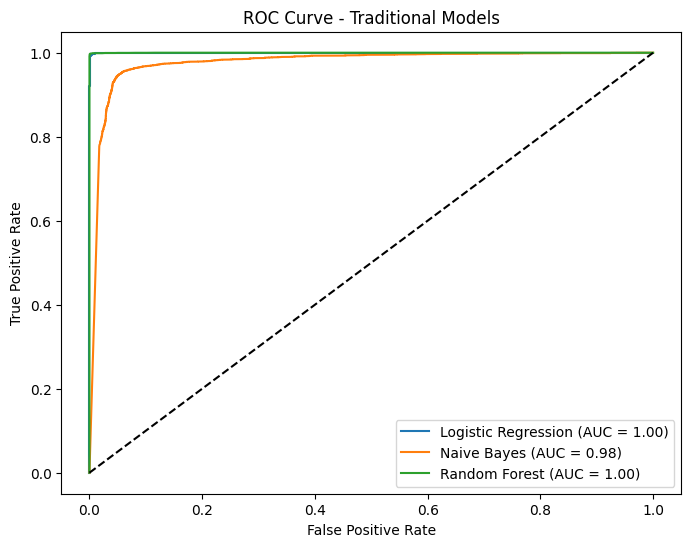

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training LSTM model...
Epoch 1/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 317ms/step - accuracy: 0.7329 - loss: 0.5236 - val_accuracy: 0.8906 - val_loss: 0.3307
Epoch 2/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.9003 - loss: 0.2968 - val_accuracy: 0.9298 - val_loss: 0.2489
Epoch 3/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 211s 340ms/step - accuracy: 0.9506 - loss: 0.1793 - val_accuracy: 0.8344 - val_loss: 0.4184
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step

LSTM Model
Accuracy: 0.8237718614236382
Precision: 0.9771039603960396
Recall: 0.6768109729961423
F1 Score: 0.7996961256014181
Confusion Matrix:
 [[4237   74]
 [1508 3158]]
Train Accuracy: 0.8312
Test Accuracy: 0.8238
Overfitting Gap (Accuracy): 0.0074


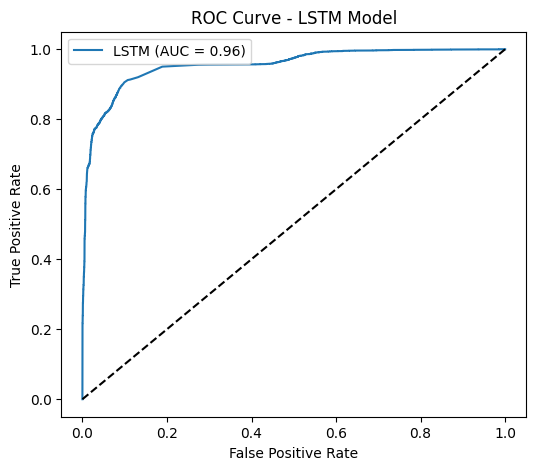

In [36]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# ---------- Preprocessing ----------
def preprocess_dataframe(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        text = re.sub(r'\d+', '', text)
        words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
        return ' '.join(words)

    df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
    df['cleaned_content'] = df['content'].apply(clean_text)
    df = df[df['cleaned_content'].str.split().str.len() > 5].copy()

    label_cols = ['label', 'is_fake', 'fake', 'target']
    label_column = next((col for col in label_cols if col in df.columns), df.columns[0])
    df['label'] = df[label_column]

    return df

# load and preprocess
df = pd.read_csv('fake_real_news.csv')
df = preprocess_dataframe(df)

# machine learning models

# feature extraction (count vectorizer)
X = df['cleaned_content']
y = df['label']
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_feature = vectorizer.fit_transform(X)

if len(vectorizer.vocabulary_) == 0:
    print("Feature extraction didn't happen.")
else:
    print("Feature extraction done.")

X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_train_pred = model.predict(X_train)



    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Overfitting Gap (Accuracy): {accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_pred):.4f}\n \n")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC Curve for ml models
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Traditional Models")
plt.legend()
plt.show()

# Lstm
# preprocessing
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_content'])
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])
X_lstm = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y_lstm = df['label'].values

X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# lstm model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining LSTM model...")
history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=3, batch_size=64, validation_split=0.2, verbose=1)


lstm_preds = lstm_model.predict(X_lstm_test).flatten()
lstm_preds_class = (lstm_preds > 0.5).astype(int)

# train and test acc for overfiting gap
train_loss, train_acc = lstm_model.evaluate(X_lstm_train, y_lstm_train, verbose=0)
test_loss, test_acc = lstm_model.evaluate(X_lstm_test, y_lstm_test, verbose=0)

print("\nLSTM Model")
print("Accuracy:", accuracy_score(y_lstm_test, lstm_preds_class))
print("Precision:", precision_score(y_lstm_test, lstm_preds_class))
print("Recall:", recall_score(y_lstm_test, lstm_preds_class))
print("F1 Score:", f1_score(y_lstm_test, lstm_preds_class))
print("Confusion Matrix:\n", confusion_matrix(y_lstm_test, lstm_preds_class))
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Overfitting Gap (Accuracy): {train_acc - test_acc:.4f}")

fpr, tpr, _ = roc_curve(y_lstm_test, lstm_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve for LSTM
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM Model")
plt.legend()
plt.show()
